In [2]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.optimize import minimize
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score, confusion_matrix
from scipy.stats import wilcoxon
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

%matplotlib inline


In [3]:
chips = pd.read_table('chips.txt', sep=',', header=None, names=['x', 'y', 'class'])
chips['Sqrt'] = (chips['x'] ** 2 + chips['y'] ** 2) ** 0.5
chips['Arct'] = np.arctan2(chips['x'], chips['y'])
x = chips[['Sqrt', 'Arct']].values
y = chips['class'].values

In [4]:
class BinSVMClassifier(BaseEstimator):
    def __init__(self, kernel='linear', C=1., kernel_param = 1.):
        self.kernel = kernel
        self.C = C
        self.kernel_f = None
        if kernel == 'linear':
            self.kernel_f = lambda x, y: np.squeeze(np.inner(x, y))
        elif kernel == 'grbf':
            self.kernel_f = lambda x, y: np.exp(-np.square(norm(x - y, axis=-1)) / kernel_param)
        elif kernel == 'triang':
            def f(x, y):
                r = norm(x - y, axis=-1)
                r = np.where(r < kernel_param, r, 0)
                return kernel_param - r
            self.kernel_f = f
        elif kernel == 'sigmoid':
            self.kernel_f = lambda x, y: np.tanh(kernel_param * np.squeeze(np.inner(x, y) + 1))
            
    def fit(self, X, y):
        self.X = X
        y_vals = np.unique(y)
        y_new = np.where(y == y_vals[0], -1, 1)
        y = y_new
        if len(y.shape) == 1:
            y = y[:, np.newaxis]
        self.y = y.flatten()
        XX = self.kernel_f(X[:, np.newaxis, ...], X[np.newaxis, ...])
        B = y.dot(y.T) * XX / 2
        A = -np.ones_like(y.T)
        y1 = y.flatten()
        loss = lambda l: (A.dot(l) + l.T.dot(B).dot(l))
        lambda_opt = minimize(fun=loss, x0=np.random.uniform(0, self.C, len(y)),
                              constraints=(
                {'type': 'eq', 'fun': lambda x: self.y.dot(x)},
                {'type': 'ineq', 'fun': lambda x: x},
                {'type': 'ineq', 'fun': lambda x: self.C - x}
            ))
        self.l = lambda_opt.x
        self.w0 = np.median(XX.dot(self.l * y1) - y1)

    def predict(self, X):
        XX = self.kernel_f(self.X[np.newaxis, ...], X[:, np.newaxis, ...])
        if XX.shape[1] != self.y.shape[0]:
            XX = XX.T
        pred = XX.dot(self.l * self.y) - self.w0
        return np.sign(pred) / 2 + 0.5


In [7]:
m = BinSVMClassifier(C=10, kernel='grbf', kernel_param = 5)
m.fit(x, y)
print(f1_score(y,m.predict(x)))
print(confusion_matrix(y, m.predict(x)))

0.857142857143
[[50 10]
 [ 7 51]]


In [8]:
nbrs = KNeighborsClassifier().fit(x, y)
print(f1_score(y, nbrs.predict(x)))
print(confusion_matrix(y, nbrs.predict(x)))


0.847457627119
[[50 10]
 [ 8 50]]


In [9]:
def fit_svm(tr, ts, C=11, kernel='grbf', kernel_param=0.87):
    x_train, x_test = x[tr], x[ts]
    y_train, y_test = y[tr], y[ts]
    m = BinSVMClassifier(C=C, kernel_param=kernel_param, kernel=kernel)
    m.fit(x_train, y_train.flatten())
    return f1_score(y_test, m.predict(x_test))

Text(0.5,1,'C against f1 score')

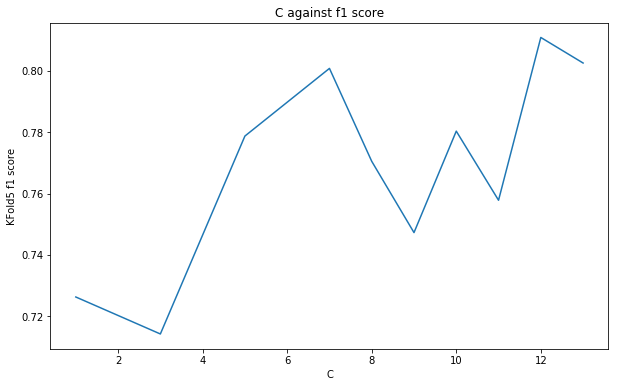

In [12]:
kf = KFold(n_splits=5, shuffle=True)

Cs = [1, 3, 5, 7, 8, 9, 10, 11, 12, 13]

def gen():
    for C in Cs:
        for (tr, ts) in kf.split(x):
            yield (tr, ts), C


Csvm = [[] for _ in range(len(Cs))]

for (tr, ts), C in gen():
    Csvm[Cs.index(C)].append(fit_svm(tr, ts, C=C))

Cy = list(map(lambda x: np.mean(x), Csvm))
plt.figure(figsize=(10, 6))
plt.plot(Cs, Cy)
plt.xlabel('C')
plt.ylabel('KFold5 f1 score')
plt.title('C against f1 score')

Text(0.5,1,'Kernel against f1 score')

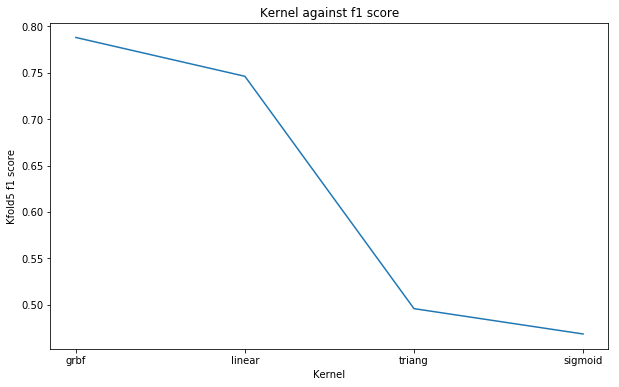

In [13]:
kf = KFold(n_splits=5, shuffle=True)

Kernels = ['grbf', 'linear', 'triang', 'sigmoid']

def genK():
    for Kernel in Kernels:
        for (tr, ts) in kf.split(x):
            yield (tr, ts), Kernel


Ksvm = [[] for _ in range(len(Kernels))]

for (tr, ts), Kernel in genK():
    Ksvm[Kernels.index(Kernel)].append(fit_svm(tr, ts, kernel=Kernel))

Ky = list(map(lambda x: np.mean(x), Ksvm))
plt.figure(figsize=(10, 6))
plt.plot([1,2,3,4], Ky)
plt.xticks([1,2,3,4], Kernels)
plt.xlabel('Kernel')
plt.ylabel('Kfold5 f1 score')
plt.title('Kernel against f1 score')

Text(0.5,1,'kernel_params against f1 score')

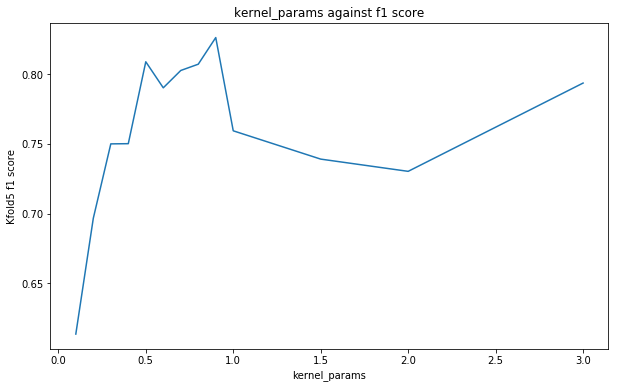

In [14]:
kf = KFold(n_splits=5, shuffle=True)

kernel_params = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2,3]

def genKp():
    for kp in kernel_params:
        for (tr, ts) in kf.split(x):
            yield (tr, ts), kp


Kpsvm = [[] for _ in range(len(kernel_params))]

for (tr, ts), param in genKp():
    Kpsvm[kernel_params.index(param)].append(fit_svm(tr, ts, kernel_param=param))

Ky = list(map(lambda x: np.mean(x), Kpsvm))
plt.figure(figsize=(10, 6))
plt.plot(kernel_params, Ky)
plt.xlabel('kernel_params')
plt.ylabel('Kfold5 f1 score')
plt.title('kernel_params against f1 score')

In [24]:
kf = KFold(n_splits=15, shuffle=True)
svm_f1 = np.array([])
knn_f1 = np.array([])
for (tr,ts) in kf.split(x):
    x_train, x_test = x[tr], x[ts]
    y_train, y_test = y[tr], y[ts]
    nbrs = KNeighborsClassifier()
    m = BinSVMClassifier(C=10, kernel='grbf', kernel_param = 1.1)
    nbrs.fit(x_train, y_train)
    m.fit(x_train, y_train)
    svm_f1 = np.append(svm_f1,f1_score(y_test, m.predict(x_test)))
    knn_f1 = np.append(knn_f1,f1_score(y_test, nbrs.predict(x_test)))




/home/petrovich/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
print(svm_f1)
print(knn_f1)


[ 0.75        1.          0.8         0.88888889  0.88888889  1.          1.
  0.5         0.90909091  0.          1.          1.          0.8         0.5
  0.8       ]
[ 0.75        0.88888889  0.5         0.75        0.88888889  0.85714286
  0.66666667  0.28571429  0.90909091  0.          0.          0.85714286
  0.66666667  0.33333333  0.8       ]


In [26]:
values = np.abs(svm_f1 - knn_f1)
signs = np.sign(svm_f1 - knn_f1)
values = values[signs != 0.]
signs = signs[signs != 0.]
R = np.argsort(values) + 1
Rplus = np.sum((signs > 0) * R, axis=0)
Rminus = np.sum((signs < 0) * R, axis=0)
W = min(Rplus, Rminus)
count = len(signs)
mn = count * (count + 1.) * 0.25
se = np.sqrt(count * (count + 1.) * (2. * count + 1.) / 24)
z = (W - mn) / se
# P(|z| > X) = p
prob = sp.stats.norm.sf(abs(z))
print('p-value ', prob)
print('W statistic ', W)

p-value  0.00253101606313
W statistic  0
WilcoxonResult(statistic=0.0, pvalue=0.0050335082006062494)


0.85


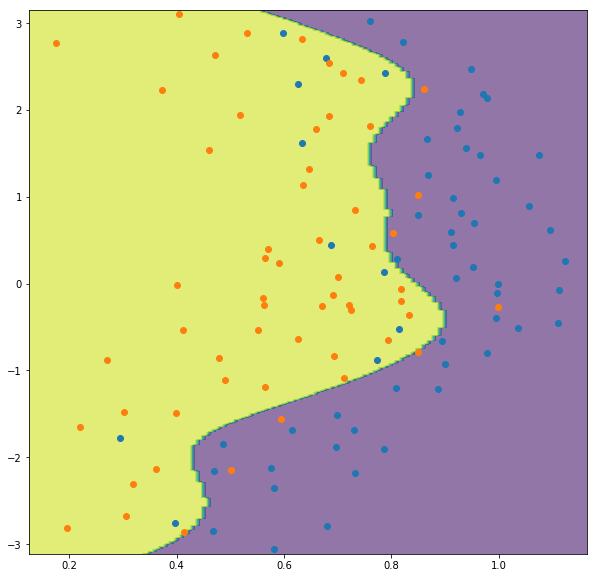

In [28]:
x_min, x_max = x.T[0].min() - .05, x.T[0].max() + .05
y_min, y_max = x.T[1].min() - .05, x.T[1].max() + .05

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

test = np.c_[xx.ravel(), yy.ravel()]
m = BinSVMClassifier(C=10, kernel='grbf', kernel_param = 1)
m.fit(x,y)
print(f1_score(y, m.predict(x)))
a = m.predict(test).reshape(xx.shape)
plt.figure(figsize=(10 ,10))
plt.contourf(xx, yy, a, alpha=.6)
plt.scatter(x[y == 0].T[0], x[y == 0].T[1])
plt.scatter(x[y == 1].T[0], x[y == 1].T[1])